This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

In [1]:
from components.gptmodel import GPTModel_v2

In [2]:
import lightning as L

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [5]:
from components.data import create_dataloader_v3

In [6]:
trainer_config = {
    "dataset_scale": 300,
    "batch_size": 32,
    "epochs": 1
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
def create_dataloader(text, train=True):
    return create_dataloader_v3(
        text,
        batch_size=trainer_config["batch_size"],
        max_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=train,
        shuffle=train,
        num_workers=11
    )

In [8]:
%%time

train_file = "../data/TinyStories/TinyStoriesV2-GPT4-train.txt"
with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read()

train_len = len(train_text)
train_text = train_text[:train_len // trainer_config["dataset_scale"]]
train_loader = create_dataloader(train_text)

CPU times: user 4.5 s, sys: 2.38 s, total: 6.88 s
Wall time: 7.02 s


In [9]:
val_file = "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt"
with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read()

val_loader = create_dataloader(val_text[:train_len//10], train=False)

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

class LitGPTModel(L.LightningModule):
    def __init__(self, GPTModel, total_steps, max_lr=1e-3):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.model = GPTModel

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.max_lr, weight_decay=0.1
        )
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.max_lr,
            total_steps=self.total_steps,
            pct_start=0.1,  # 10% warmup
            anneal_strategy='cos'
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

In [11]:
model = GPTModel_v2(GPT_CONFIG_124M)
litmodel = LitGPTModel(model, 1 + trainer_config["epochs"]*len(train_loader)//trainer_config["grad_batches"])

In [12]:
%%time

trainer = L.Trainer(max_epochs=trainer_config["epochs"], enable_progress_bar=True, accumulate_grad_batches=trainer_config["grad_batches"])
trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/envs/fromscratch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | GPTModel_v2 | 43.5 M | train
------------------------

Sanity Checking: |                                                                             | 0/? [00:00<?,…

Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 3min 39s, sys: 3.61 s, total: 3min 43s
Wall time: 3min 44s


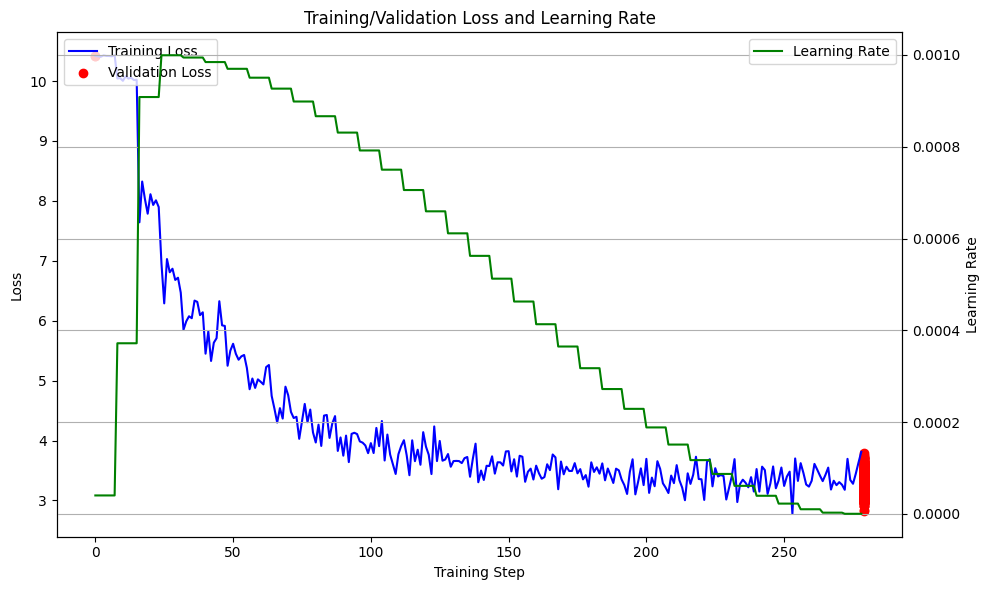

In [13]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

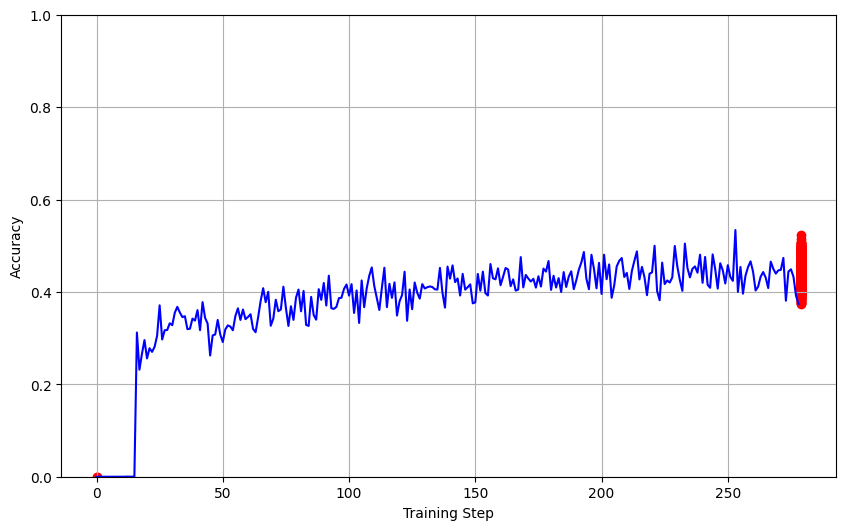

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [15]:
from tokenizers import Tokenizer

In [16]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [17]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [18]:
from components.generatetext import generate_text

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

GPTModel_v2(
  (tok_emb): Embedding(30002, 512)
  (pos_emb): Embedding(256, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_v2(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock_v2(
     

In [40]:
%%time
litmodel.eval()
text = generate_text(litmodel.model, tokenizer, "Once upon a time there ", 1000, device, topk=3, temperature=5)
print("text: ", text)

text:  Once upon a time there, there. One a time, " I. One a little girl was very a time, there to play and the ball a time, but the tree and the ball a little. He saw a little. He was a big, but the tree, but it. He saw the tree. The dog, but he was so. He had. The bird, and the ball.
CPU times: user 363 ms, sys: 19.6 ms, total: 383 ms
Wall time: 391 ms
